# Transport for London (TfL) Journeys - Exploratory Data Analysis

### Contents
1. [Introduction](#Introduction)
2. [The Dataset](#The-Dataset)
3. [Analysis](#Analysis)
4. [Solving the Problem - Overcrowded Stations](#Solving-the-Problem---Overcrowded-Stations)

## Introduction 

This is an exploratory data analysis project. The aim of this project is to identify the main characteristics of the dataset, extract information without using a formal model and display insights visually in a way that would be understood by stakeholders.



I chose this dataset to analyse, because I am a regular user of the Transport for London (TfL) network. I find myself constantly trying to avoid travelling during busier times or at busier stations. I thought that it would be interesting to analyse the data from the point of view of a TfL employee who is trying to reduce overcrowded stations.

## The Dataset

https://www.kaggle.com/datasets/astronasko/transport-for-london-journey-information

The dataset contains data on Oyster Card journeys from a week in November of 2009. Oyster cards are reusable cards used for ticketing purposes on the TfL network, so they can be used on buses, underground trains, tram lines etc.

The features in the dataset are either about the journey taken (e.g. Start/Exit station, Route numbers) or the Oyster Card type. 

### Limitations of the Dataset 

- All the data is from a single week in November 2009, and it may not be representative of all weeks.
- Since the data is from over 15 years ago, it may inaccurately describe what journeys would look like today. Many things have changed such as new service lines, different payment methods. Because of this, I want to ensure that any analysis applied on this dataset could be applied on a dataset from 2024 as well.

## Analysis

Questions to answer in the initial analysis:
- How many journeys were made for each mode of transport (i.e. bus, DLR, underground etc.)?
- What is the distribution of journey start times? This can help to identify the busiest times.
- Which stations are used the most?

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import time
import math
import folium

In [2]:
df = pd.read_csv("Nov09JnyExport.csv")
df.head()

,downo,daytype,SubSystem,StartStn,EndStation,EntTime,EntTimeHHMM,ExTime,EXTimeHHMM,ZVPPT,JNYTYP,DailyCapping,FFare,DFare,RouteID,FinalProduct
0,3,Tue,LUL,Unstarted,Kings Cross M,0,00:00,633,10:33,Z0104,TKT,N,0,0,XX,LUL Travelcard-7 Day
1,4,Wed,LUL,Unstarted,Sudbury Hill,0,00:00,447,07:27,Z0110,TKT,N,0,0,XX,Freedom Pass (Elderly)
2,3,Tue,NR,Unstarted,Richmond,0,00:00,966,16:06,Z0304,TKT,N,0,0,XX,LUL Travelcard-7 Day
3,4,Wed,NR,Unstarted,Romford,0,00:00,657,10:57,Z0110,TKT,N,0,0,XX,Freedom Pass (Elderly)
4,6,Fri,NR,Unstarted,Norwood Junction SR,0,00:00,450,07:30,Z0104,TKT,N,0,0,XX,LUL Travelcard-7 Day


In [3]:
row_count = len(df)
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2623487 entries, 0 to 2623486
Data columns (total 16 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   downo         2623487 non-null  int64 
 1   daytype       2623487 non-null  object
 2   SubSystem     2623487 non-null  object
 3   StartStn      2623487 non-null  object
 4   EndStation    2623487 non-null  object
 5   EntTime       2623487 non-null  int64 
 6   EntTimeHHMM   2623487 non-null  object
 7   ExTime        2623487 non-null  int64 
 8   EXTimeHHMM    2623487 non-null  object
 9   ZVPPT         2623487 non-null  object
 10  JNYTYP        2623487 non-null  object
 11  DailyCapping  2623487 non-null  object
 12  FFare         2623487 non-null  int64 
 13  DFare         2623487 non-null  int64 
 14  RouteID       2623487 non-null  object
 15  FinalProduct  2623487 non-null  object
dtypes: int64(5), object(11)
memory usage: 320.3+ MB


The data has 2623487 rows. The summary above shows that there are no Null values.

I'm going to find out which mode of transport is most popular.

In [4]:
df['SubSystem'].value_counts()

SubSystem
LTB           1768080
LUL            723126
NR              47715
LUL/NR          25990
LUL/DLR         13911
TRAM             9583
DLR              9224
LUL/NR/LRC       8262
NR/LRC           6665
LRC              3713
LUL/LRC          3293
LUL/NR/DLR       2812
HEX               760
NR/DLR            263
LUL/TRAM           86
DLR/LRC             4
Name: count, dtype: int64

The top three modes of transport London Buses (LTB), London Underground (LUL) and National Rail (NL) make up 97% of all journeys.

What is the distribution of journey start times?

<function matplotlib.pyplot.show(close=None, block=None)>

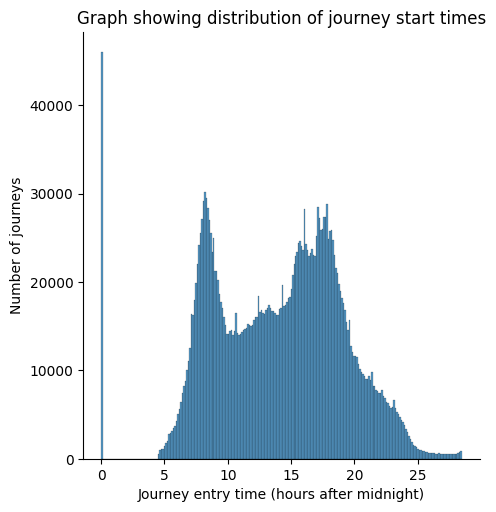

In [5]:
# EntTime is in minutes after midnight on the first day of data collection, which is quite difficult to read.
# Below, this is converted to hours after midnight
df["EntTimeHoursAfterMidnight"] = df["EntTime"]/60

ax = sns.displot(df, x="EntTimeHoursAfterMidnight")
ax.set(xlabel="Journey entry time (hours after midnight)", ylabel='Number of journeys', title="Graph showing distribution of journey start times")
plt.show

From the graph, we can see that the data collection starts just before 5am on the first day and stops at around the same time the next day.

It seems that the peak times for journeys started are around 8am and between 3pm and 6pm, which aligns with peak hours when people are travelling to and from work.
Between these times, there are also a considerable amount of journeys. 

However, between 1am and 5am there are very little journeys started.

What about the sharp spike of data at 0 (midnight)? It's unlikely that data collection was occuring at this time, as most of the data starts at 5am. Even if data was being collected, I would not expect over 40,000 journeys to have started at this time, as the number is at around 2000 the next day.

I expect this has to do with 'unstarted' journeys (where the customer may have forgotten to 'tap' their Oyster card on entering the TfL Network). I'm going to verify this.

In [6]:
row_count = len(df)
ent_time_0_count = len(df[df.EntTime == 0])
unstarted_journey_count = len(df[df.StartStn == "Unstarted"])
print("Number of journies that started at midnight: ", ent_time_0_count)
print("Number of 'unstarted' journies: ", unstarted_journey_count)
print("\'Unstarted\' journies make up {}% of all journies ".format(unstarted_journey_count*100/row_count))

Number of journies that started at midnight:  45989
Number of 'unstarted' journies:  45994
'Unstarted' journies make up 1.7531628706374378% of all journies 


The numbers seem to confirm that the spike of journeys 'started' at midnight can be explained by the number of unstarted journeys.

Since these journeys make up less than 2% of all journeys, it would be safe to drop these instances if needed.

Next, I want to find out which stations are the busiest. This will be informative when trying to reduce overcrowding on the network.

In [7]:
# Combine the start and end stations into a series.
# Ignoring bus journeys as their stations are just recorded as 'Bus'
start_stations = df[~df.StartStn.isin(["Unstarted", "Bus"])]["StartStn"]
end_stations = df[~df.EndStation.isin(["Unfinished", "Bus"])]["EndStation"]
all_stations = start_stations._append(end_stations, ignore_index=True)

# Count the frequency of each station
all_stations_count = all_stations.value_counts()

all_stations_count

Oxford Circus                     40024
Victoria                          35314
London Bridge                     32879
Liverpool Street                  30667
Canary Wharf                      24326
                                  ...  
Sudbury Hill Harrow                  24
Sudbury&Harrow Rd                    12
Bellingham                            3
BLCKHRS LNE TRAM                      2
Harringay                             1
Name: count, Length: 453, dtype: int64

There are 453 stations recorded (note: some stations with multiple entrances/exits are recorded as separate stations). There is a large difference in counts between the most and least popular stations.

Next, I'm going to plot the frequencies for the top 7 stations.

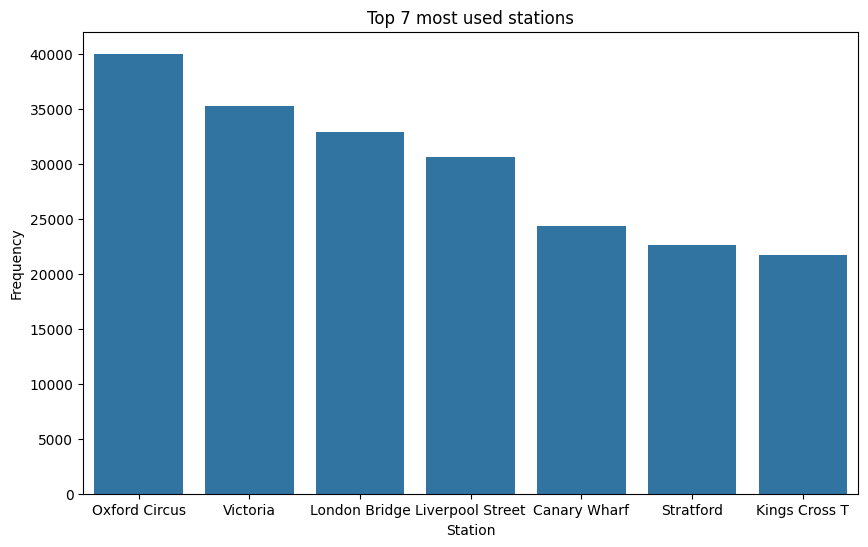

In [8]:
stations_highest_count = all_stations_count.nlargest(7)
stations_highest_count_df = stations_highest_count.reset_index()
stations_highest_count_df.columns = ['Station', 'Frequency']

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x='Station', y='Frequency', data=stations_highest_count_df)
plt.title('Top 7 most used stations')
plt.xlabel('Station')
plt.ylabel('Frequency')
plt.show()

## Solving the Problem - Overcrowded Stations

I found a list of stations and their coordinates provided by a TfL FOI request here: https://tfl.gov.uk/corporate/transparency/freedom-of-information/foi-request-detail?referenceId=FOI-1451-1819

I will use this to show the most popular stations and quieter surrounding stations.

In [9]:
station_df = pd.read_csv("station_coordinates.csv", index_col=[0])
station_df.head()

,OBJECTID,NAME,EASTING,NORTHING,LINES,NETWORK,Zone,x,y
FID,,,,,,,,,
0,78,Temple,530959,180803,"District, Circle",London Underground,1,-0.112644,51.510474
1,79,Blackfriars,531694,180893,"District, Circle",London Underground,1,-0.102020,51.511114
2,80,Mansion House,532354,180932,"District, Circle",London Underground,1,-0.092495,51.511306
3,81,Cannon Street,532611,180900,"District, Circle",London Underground,1,-0.088801,51.510963
4,82,Monument,532912,180824,"District, Circle",London Underground,1,-0.084502,51.510209


In [10]:
# Some stations e.g. Liverpool Street have more than one row (as they have multiple entrances)
station_df = station_df.drop_duplicates(subset='NAME', keep='first')

In [11]:
all_stations_count = all_stations_count.reset_index()
all_stations_count.columns = ["Station", "Frequency"]
all_stations_count.to_csv("all_Stations")

In [12]:
# Multiple entries for Kings Cross, so I'm going to combine them into one
all_kings_x_stations = all_stations_count[all_stations_count['Station'].str.startswith('Kings Cross')]
kings_cross_total_frequency = all_kings_x_stations.Frequency.sum()
all_stations_count.loc[len(all_stations_count), all_stations_count.columns] = "King's Cross St. Pancras", kings_cross_total_frequency
all_stations_count = all_stations_count[~all_stations_count['Station'].isin(all_kings_x_stations['Station'])]

In [13]:
# Add the number of journeys for each station to the station_df DataFrame
def get_journey_count(station_name):
    if station_name in all_stations_count["Station"].values:
        return all_stations_count.loc[all_stations_count["Station"] == station_name]["Frequency"].iloc[0]
    return 0

station_df["journey_count"] = station_df["NAME"].apply(lambda x: get_journey_count(x))
station_df.head()

,OBJECTID,NAME,EASTING,NORTHING,LINES,NETWORK,Zone,x,y,journey_count
FID,,,,,,,,,,
0,78,Temple,530959,180803,"District, Circle",London Underground,1,-0.112644,51.510474,6055.0
1,79,Blackfriars,531694,180893,"District, Circle",London Underground,1,-0.102020,51.511114,438.0
2,80,Mansion House,532354,180932,"District, Circle",London Underground,1,-0.092495,51.511306,4650.0
3,81,Cannon Street,532611,180900,"District, Circle",London Underground,1,-0.088801,51.510963,2554.0
4,82,Monument,532912,180824,"District, Circle",London Underground,1,-0.084502,51.510209,5328.0


I want to display the stations and how popular they are visually. I will do this by displaying them on a map with a circle representing each station. 

I'll highlight the most popular stations in red and change the radius of the circles depending on how busy they are.

I will also only show stations in Zone 1 to 3 as all the busy stations are within these zones.

In [14]:
m = folium.Map(location=[51.51398203, -0.0742363], tiles='OpenStreetMap', zoom_start=12)
busy_stations = ["Oxford Circus", "Victoria", "London Bridge", "Liverpool Street", "Canary Wharf",
                "Stratford", "King's Cross St. Pancras"]

for i in range(0, len(station_df)):
    station_name = station_df.iloc[i]['NAME']
    station_zone = station_df.iloc[i]['Zone']
    color = 'blue'
    if station_name in busy_stations:
        color='red'
    if station_zone in [1, 2, 3]:
        folium.Circle(
            location = [station_df.iloc[i]['y'], station_df.iloc[i]['x']],
            popup= station_name,
            radius = float(station_df.iloc[i]["journey_count"])/100,
            color=color,
            fill=True,
            fill_color=color
        ).add_to(m)
m

### Note: map cannot be rendered when viewing in Github
Please follow this link to see the map: https://nbviewer.org/github/hannasophian/oyster_journeys/blob/main/data_exploration.ipynb

This can be used to direct customers to nearby, less busy stations

For example, customers who usually go to Liverpool Street Station could instead use Moorgate or Aldgate.

Limitations: 
- The dataset used to determine how busy stations is from 2009 and may not represent behaviours for today.
- This doesn't consider how well stations can accommodate larger crowds. Bigger stations like King's Cross can manage more passengers than smaller ones like Aldgate East.